In [2]:
# importation
import numpy as np
import dataclasses
from LSTM_GNN import DataLoader, LSTMoutput
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas as pd
from nltk import FreqDist
import matplotlib.pyplot as plt
import warnings
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"    # 想要禁言tf
warnings.filterwarnings('ignore')    #同上
pd.set_option('display.max_columns', None)    #看全列名

In [4]:
# 创建类方便存储各项属性，主要用在寻找hub-spoke的对应关系
class Airport:
    def __init__(self, name, code, operation = 0):
        self.name = name  # 随便的名字
        self.code = code    # ！机场代码
        self.operation = operation    # 航班数量
    
    def update_operation(self, operation):    # 更改航班数
        self.operation = operation
        return 0
    
    
class Hub(Airport):
    def __init__(self, name, code, operation, spokelist: list):
        super(Hub, self).__init__(name, code, operation)  #继承
        self.spokes = list(set(spokelist))  #避免重复，对象为object
        self.spoke_codes = []
        for spoke in self.spokes:    # 记录spoke的代码，对象为str
            spoke.change_hub(self)
            self.spoke_codes.append(spoke.code)
    
    def reset_spoke(self, spokelist: list):    #重设spoke
        self.spokes = list(set(spokelist))
        return 0
    
    def add_spoke(self, spokelist: list):    #添加spoke
        for spoke in spokelist:
            self.spokes.append(spoke)
            self.spoke_codes.append(spoke.code)
        self.spokes = list(set(self.spokes))
        self.spoke_codes = list(set(self.spoke_codes))
        return 0
        
class Spoke(Airport):
    def __init__(self, name, code, operation, hub: Hub):
        super(Spoke, self).__init__(name, code, operation)
        self.hub = hub
        hub.add_spoke([self])
        
    def change_hub(self,hub: Hub):
        self.hub = hub
        return 0
        

In [35]:
#sfo = Hub('sanfran','SFO',20,[])
#oak = Spoke('oakland','OAK',5,sfo)
#lax = Spoke('losang','LAX',15,sfo)

In [3]:
df = pd.read_csv('/Users/wilsonwang/Documents/PycharmProjects/pythonProject/CE290/data/jan2020.csv', skiprows=1, nrows=79373)    #以一月的数据确认对应关系

In [5]:
#目标：SLC
dep_slc = df[df['Departure']=='SLC'][['Arrival','Flight\nCount']]  #SLC 出发的
depdict = {}
for key in set(dep_slc['Arrival']):    # 每个目的地作为key
    depdict[key] = np.sum(dep_slc[dep_slc['Arrival']==key]['Flight\nCount'])   # 目的地的航班数作为value
dep_slc = pd.DataFrame.from_dict(depdict,orient='index',columns=['# of flights'])    # 将dict转为df方便画图
dep_slc = dep_slc.reset_index().rename(columns={'index':'Facility'})

arr_slc = df[df['Arrival']=='SLC'][['Departure','Flight\nCount']]    #到达SLC的，下同
arrdict = {}
for key in set(arr_slc['Departure']):
    arrdict[key] = np.sum(arr_slc[arr_slc['Departure']==key]['Flight\nCount'])
arr_slc = pd.DataFrame.from_dict(arrdict,orient='index',columns=['# of flights'])
arr_slc = arr_slc.reset_index().rename(columns={'index':'Facility'})

(array([18.,  6., 10.,  5.,  2.,  2.,  3.,  4.,  1.,  1.,  2.,  2.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([  1.  ,  31.45,  61.9 ,  92.35, 122.8 , 153.25, 183.7 , 214.15,
        244.6 , 275.05, 305.5 , 335.95, 366.4 , 396.85, 427.3 , 457.75,
        488.2 , 518.65, 549.1 , 579.55, 610.  ]),
 <BarContainer object of 20 artists>)

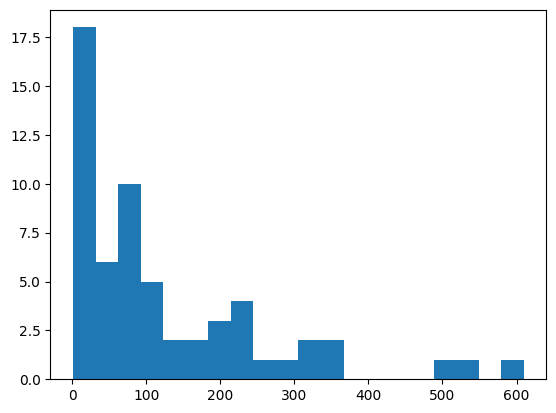

In [5]:
plt.hist(arr_slc['# of flights'],bins=20)    # 画图以寻找筛选spoke的标准

In [6]:
dep_slc[(dep_slc['# of flights']>=62) & (dep_slc['# of flights']<=123)]  # 以平均每天2-3班为标准选择spoke

,Facility,# of flights
3,TUS,80
10,ABQ,89
14,AUS,95
21,FLL,66
25,ONT,86
30,BWI,62
31,MCO,107
41,EWR,118
45,PSP,95
52,SAT,63


In [7]:
arr_slc[(arr_slc['# of flights']>=62) & (arr_slc['# of flights']<=123)]    # 到达SLC只比出发的多一个MDW，舍去MDW，以出发结果为准↑

,Facility,# of flights
3,TUS,81
9,ABQ,89
13,AUS,94
18,FLL,65
19,MDW,63
22,ONT,87
26,BWI,62
28,MCO,107
38,EWR,117
41,PSP,96


In [8]:
#以某个日期在各个机场的各自总航班数作为self的属性批量建立Spoke对象与Hub对象
select_date = '01/01/2020'
oper_slc = np.sum(df[(df['Departure']=='SLC') & (df['Date']==select_date)]['Flight\nCount']) + np.sum(df[(df['Arrival']=='SLC') & (df['Date']==select_date)]['Flight\nCount'])
slc = Hub('salt_lake','SLC',oper_slc,[])
for spoke in dep_slc[(dep_slc['# of flights']>=62) & (dep_slc['# of flights']<=123)]['Facility']:
    n_oper = np.sum(df[(df['Departure']==spoke) & (df['Date']==select_date)]['Flight\nCount']) + np.sum(df[(df['Arrival']==spoke) & (df['Date']==select_date)]['Flight\nCount'])
    locals()[spoke.lower()] = Spoke('name of '+spoke,spoke,n_oper,slc)


In [9]:
# 建立hub，spoke们和77*121 matrix行的对应index
hub_index = 68
spoke_index = []
for i in range(len(df['Departure'].unique())):
    if df['Departure'].unique()[i] in slc.spoke_codes:
        print(i,df['Departure'].unique()[i])
        spoke_index.append(i)

0 ABQ
3 AUS
7 BOS
10 BWI
19 DTW
20 EWR
21 FLL
36 MCI
37 MCO
48 ONT
56 PSP
62 SAT
71 STL
75 TUS


In [9]:
old_input = pd.read_csv('save.csv')  # 原matrix

In [13]:
#以下是出问题的部分

# model的一些设定值，参考LSTM_GNN_Example.ipynb
start_day = 40
n_training = 28+28*1
n_test =7

change_list = [0]*len(spoke_index)



In [14]:
#以原数据训练model
loader = DataLoader('save.csv', start_day, n_training, 21, n_test)
x_train, y_train, x_test = loader.train_test_split()

model = Sequential()
model.add(LSTM(loader.n_pred*77, batch_input_shape=(loader.n_batch,loader.n_timesteps,77)))
model.add(Dense(loader.n_pred*77//2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(loader.n_pred*77, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=14)
#训练完， 下面直接用model

Epoch 1/100
2/2 [==============================] - 1s 54ms/step - loss: 1.0672
Epoch 2/100
2/2 [==============================] - 0s 52ms/step - loss: 0.9243
Epoch 3/100
2/2 [==============================] - 0s 54ms/step - loss: 0.7501
Epoch 4/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6009
Epoch 5/100
2/2 [==============================] - 0s 49ms/step - loss: 0.4655
Epoch 6/100
2/2 [==============================] - 0s 54ms/step - loss: 0.3796
Epoch 7/100
2/2 [==============================] - 0s 52ms/step - loss: 0.3035
Epoch 8/100
2/2 [==============================] - 0s 47ms/step - loss: 0.2739
Epoch 9/100
2/2 [==============================] - 0s 47ms/step - loss: 0.2484
Epoch 10/100
2/2 [==============================] - 0s 56ms/step - loss: 0.2311
Epoch 11/100
2/2 [==============================] - 0s 52ms/step - loss: 0.2290
Epoch 12/100
2/2 [==============================] - 0s 54ms/step - loss: 0.2092
Epoch 13/100
2/2 [==============================]

2/2 [==============================] - 0s 46ms/step - loss: 0.0765
Epoch 97/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0740
Epoch 98/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0752
Epoch 99/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0679
Epoch 100/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0726


In [ ]:
    def train_test_split(self):
        self.train = self.x[:,self.start_day:self.start_day+self.n_training]
        self.scale = StandardScaler()
        self.train = self.scale.fit_transform(self.train.T).T
        self.x_train = np.zeros(shape=(self.n_batch, self.n_timesteps, 77))
        self.y_train = np.zeros(shape=(self.n_batch, 77*self.n_pred))
        for i in range(self.n_batch):
            self.x_train[i,:,:] = self.train[:,i:i+self.n_timesteps].T
            self.y_train[i,:] = self.train[:,i+self.n_timesteps:i+self.n_timesteps+self.n_pred].flatten()

        # +1 is added here to resolve the issue that the state of LSTM is 0 for the first element
        self.test = self.x[:,self.start_day+self.n_pred+1:]
        self.test = self.scale.transform(self.test.T).T
        self.x_test = np.zeros(shape=(self.n_batch, self.n_timesteps, 77))
        for i in range(self.n_batch):
            self.x_test[i,:,:] = self.test[:,i:i+self.n_timesteps].T
        return tf.convert_to_tensor(self.x_train), tf.convert_to_tensor(self.y_train), tf.convert_to_tensor(self.x_test)


In [15]:
max_flight = 2
for add_flight in range(1,max_flight):  # 这个for目前没有作用，为了方便之后添加多个航班到不同机场做准备
    print('add flight num: ',add_flight)
    for i in range(len(spoke_index)):
        change_list = [0]*len(spoke_index)    # tbd when max>2
        change_list[i] = 1    # 分别在每个spoke上加一班，改这里可以在各个spoke上加n班
        
        #使用之前定义好的func
        new_input = update_input(old_input, hub_index, spoke_index, start_day+n_training, n_test, change_list)
        
        #方便输入loader，先输出成和save.csv类似的csv
        file_name = 'add_'+str(add_flight)+'_to_'+df['Departure'].unique()[spoke_index[i]]+'.csv'
        new_input.to_csv(file_name,index=False,header=True)
        
        # 提取新的x_test
        loader = DataLoader(file_name, start_day, n_training, 21, n_test)
        x_train, y_train, x_test = loader.train_test_split()
        
        predicted = model.predict(x_test)
        
        score = 0  #存储最后7天整个网络的日平均总航班数
        for j in range(77):
            result = LSTMoutput(loader, j)
            result.inverse_transform(predicted)
            score = score + np.sum(result.predicted_transformed[-1-n_test:-1])    # 最后7天
        score = score/n_test
        print('add to: ', df['Departure'].unique()[spoke_index[i]])
        print('score: ', score)

# 输出结果不管怎么改change_list，得出的score都是一样的

add flight num:  1
add to:  ABQ
score:  12232.55563525004
add to:  AUS
score:  12232.55563525004
add to:  BOS
score:  12232.55563525004
add to:  BWI
score:  12232.55563525004
add to:  DTW
score:  12232.55563525004
add to:  EWR
score:  12232.55563525004
add to:  FLL
score:  12232.55563525004
add to:  MCI
score:  12232.55563525004
add to:  MCO
score:  12232.55563525004
add to:  ONT
score:  12232.55563525004
add to:  PSP
score:  12232.55563525004
add to:  SAT
score:  12232.55563525004
add to:  STL
score:  12232.55563525004
add to:  TUS
score:  12232.55563525004


In [6]:
dep_slc

,Facility,# of flights
0,VNY,27
1,RDU,30
2,TUS,80
3,PHL,40
4,ONT,86
...,...,...
58,PVD,1
59,PDX,239
60,HPN,4
61,IND,28


In [11]:
df['Departure'].unique()

array(['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF',
       'BUR', 'BWI', 'CLE', 'CLT', 'CVG', 'DAL', 'DAY', 'DCA', 'DEN',
       'DFW', 'DTW', 'EWR', 'FLL', 'GYY', 'HNL', 'HOU', 'HPN', 'IAD',
       'IAH', 'IND', 'ISP', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LGB',
       'MCI', 'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MSP', 'MSY',
       'OAK', 'OGG', 'OMA', 'ONT', 'ORD', 'OXR', 'PBI', 'PDX', 'PHL',
       'PHX', 'PIT', 'PSP', 'PVD', 'RDU', 'RFD', 'RSW', 'SAN', 'SAT',
       'SDF', 'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL',
       'SWF', 'TEB', 'TPA', 'TUS', 'VNY'], dtype=object)

In [10]:
old_input

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
0,129.0,139.0,141.0,112.0,137.0,135.0,117.0,118.0,124.0,115.0,72.0,114.0,123.0,115.0,115.0,124.0,125.0,77.0,110.0,126.0,117.0,113.0,123.0,125.0,76.0,119.0,120.0,116.0,116.0,124.0,128.0,77.0,112.0,122.0,119.0,109.0,133.0,124.0,81.0,119.0,130.0,100.0,117.0,133.0,137.0,92.0,111.0,137.0,134.0,129.0,140.0,134.0,95.0,122.0,135.0,130.0,131.0,134.0,134.0,92.0,119.0,141.0,138.0,130.0,133.0,141.0,111.0,126.0,132.0,127.0,131.0,135.0,140.0,107.0,125.0,132.0,126.0,123.0,120.0,113.0,89.0,103.0,101.0,99.0,80.0,85.0,64.0,65.0,74.0,63.0,54.0,65.0,68.0,61.0,45.0,58.0,55.0,48.0,51.0,57.0,48.0,38.0,60.0,56.0,50.0,48.0,40.0,38.0,27.0,36.0,40.0,43.0,33.0,31.0,43.0,33.0,35.0,39.0,41.0,37.0,44.0
1,82.0,98.0,96.0,106.0,104.0,81.0,81.0,86.0,102.0,89.0,99.0,97.0,81.0,79.0,90.0,103.0,89.0,100.0,103.0,82.0,81.0,91.0,99.0,84.0,93.0,88.0,69.0,59.0,65.0,76.0,65.0,71.0,76.0,59.0,59.0,69.0,82.0,75.0,82.0,86.0,66.0,66.0,77.0,92.0,84.0,91.0,90.0,79.0,68.0,91.0,93.0,89.0,106.0,88.0,79.0,75.0,86.0,103.0,91.0,103.0,98.0,85.0,74.0,91.0,103.0,97.0,106.0,102.0,91.0,82.0,100.0,105.0,101.0,109.0,105.0,107.0,79.0,110.0,111.0,99.0,103.0,104.0,97.0,89.0,95.0,100.0,92.0,95.0,95.0,89.0,70.0,84.0,82.0,75.0,82.0,83.0,70.0,69.0,83.0,82.0,70.0,75.0,80.0,62.0,68.0,81.0,75.0,74.0,77.0,80.0,72.0,67.0,82.0,76.0,73.0,82.0,78.0,79.0,72.0,80.0,87.0
2,1110.0,1315.0,1303.0,1085.0,1358.0,1428.0,1374.0,1388.0,1433.0,1396.0,995.0,1319.0,1422.0,1376.0,1386.0,1420.0,1401.0,957.0,1095.0,1382.0,1377.0,1386.0,1419.0,1400.0,996.0,1310.0,1411.0,1367.0,1381.0,1406.0,1408.0,984.0,1150.0,1413.0,1382.0,1368.0,1401.0,1419.0,1011.0,1312.0,1413.0,1379.0,1384.0,1410.0,1401.0,977.0,1106.0,1381.0,1388.0,1393.0,1415.0,1400.0,1006.0,1307.0,1413.0,1393.0,1402.0,1422.0,1420.0,1009.0,1317.0,1421.0,1392.0,1396.0,1425.0,1423.0,1058.0,1323.0,1425.0,1404.0,1425.0,1498.0,1479.0,1198.0,1420.0,1482.0,1351.0,1347.0,1135.0,900.0,870.0,777.0,685.0,680.0,680.0,712.0,625.0,570.0,559.0,632.0,539.0,537.0,498.0,483.0,415.0,438.0,481.0,434.0,442.0,439.0,443.0,383.0,425.0,424.0,388.0,362.0,346.0,353.0,306.0,325.0,345.0,317.0,319.0,327.0,333.0,294.0,331.0,324.0,322.0,342.0,321.0
3,324.0,351.0,354.0,297.0,342.0,348.0,333.0,338.0,362.0,346.0,247.0,343.0,351.0,332.0,343.0,367.0,356.0,240.0,322.0,348.0,331.0,343.0,364.0,354.0,250.0,345.0,352.0,344.0,337.0,369.0,364.0,249.0,338.0,362.0,333.0,337.0,357.0,366.0,250.0,351.0,350.0,327.0,335.0,366.0,368.0,270.0,333.0,369.0,357.0,352.0,368.0,366.0,267.0,361.0,368.0,349.0,351.0,371.0,371.0,265.0,359.0,376.0,355.0,355.0,381.0,389.0,305.0,374.0,385.0,365.0,380.0,379.0,401.0,317.0,391.0,376.0,344.0,347.0,345.0,306.0,239.0,283.0,235.0,241.0,219.0,207.0,169.0,169.0,189.0,161.0,155.0,157.0,152.0,162.0,122.0,144.0,136.0,106.0,109.0,124.0,116.0,87.0,98.0,109.0,115.0,117.0,101.0,102.0,64.0,95.0,101.0,93.0,94.0,106.0,100.0,59.0,85.0,87.0,87.0,96.0,97.0
4,118.0,141.0,139.0,119.0,140.0,142.0,129.0,137.0,139.0,143.0,132.0,138.0,137.0,133.0,138.0,138.0,132.0,129.0,124.0,132.0,130.0,140.0,144.0,140.0,130.0,136.0,136.0,127.0,133.0,138.0,143.0,122.0,125.0,138.0,124.0,130.0,132.0,144.0,124.0,132.0,135.0,127.0,135.0,143.0,151.0,137.0,140.0,147.0,150.0,150.0,150.0,148.0,141.0,146.0,149.0,146.0,150.0,151.0,149.0,137.0,144.0,146.0,145.0,152.0,148.0,148.0,132.0,140.0,140.0,143.0,143.0,139.0,142.0,131.0,135.0,137.0,132.0,129.0,123.0,106.0,115.0,112.0,91.0,83.0,76.0,79.0,60.0,65.0,58.0,54.0,47.0,60.0,51.0,53.0,58.0,61.0,59.0,61.0,65.0,69.0,68.0,62.0,52.0,53.0,44.0,47.0,43.0,43.0,37.0,34.0,36.0,39.0,39.0,42.0,45.0,41.0,34.0,48.0,42.0,45.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...